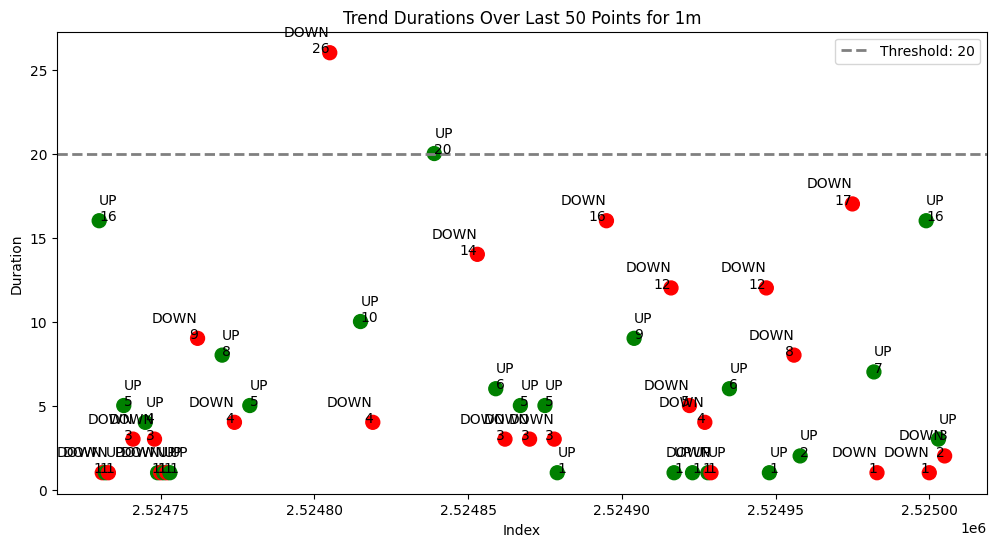

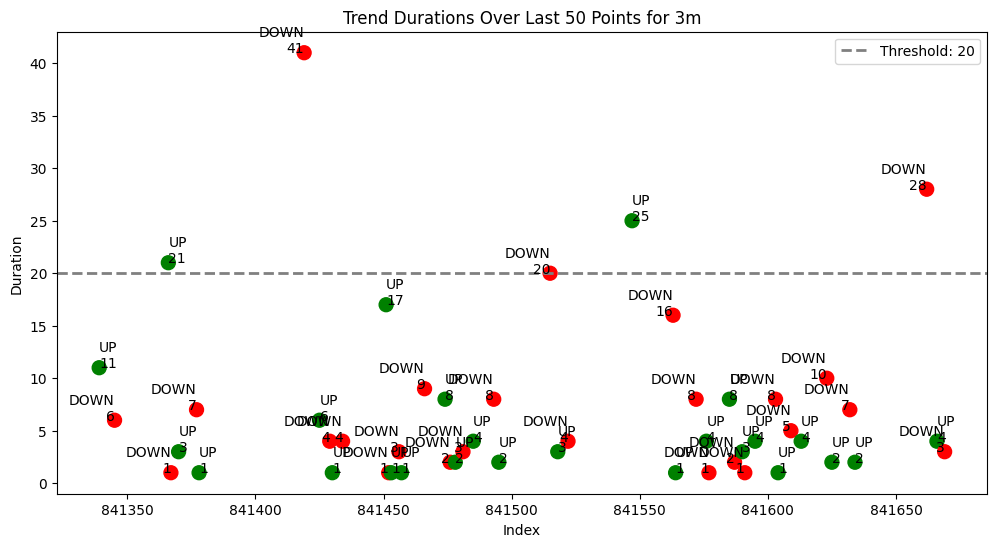

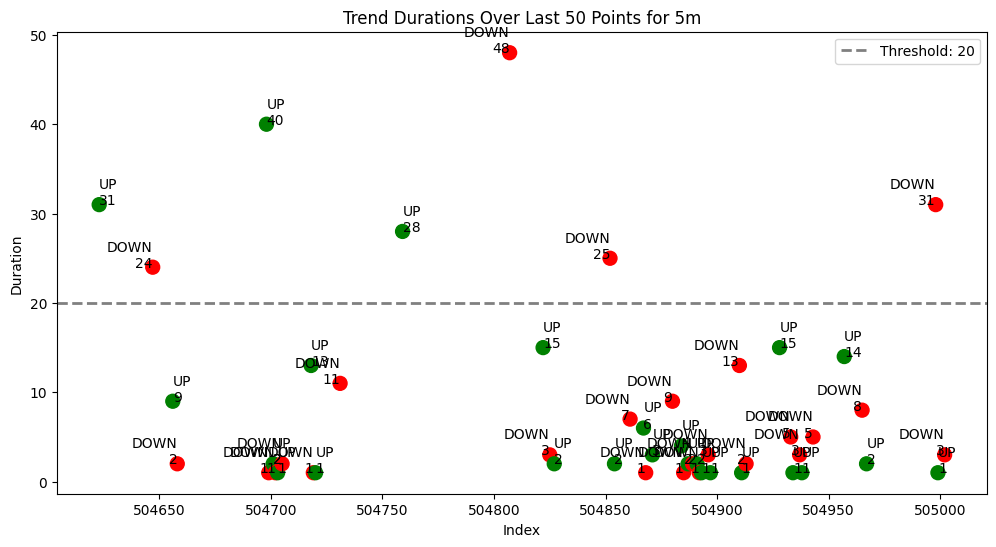

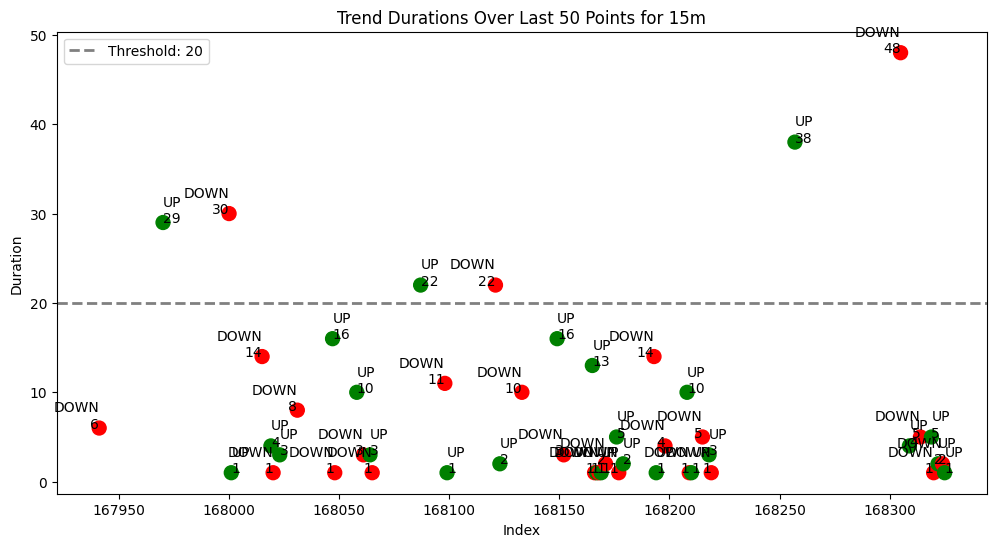

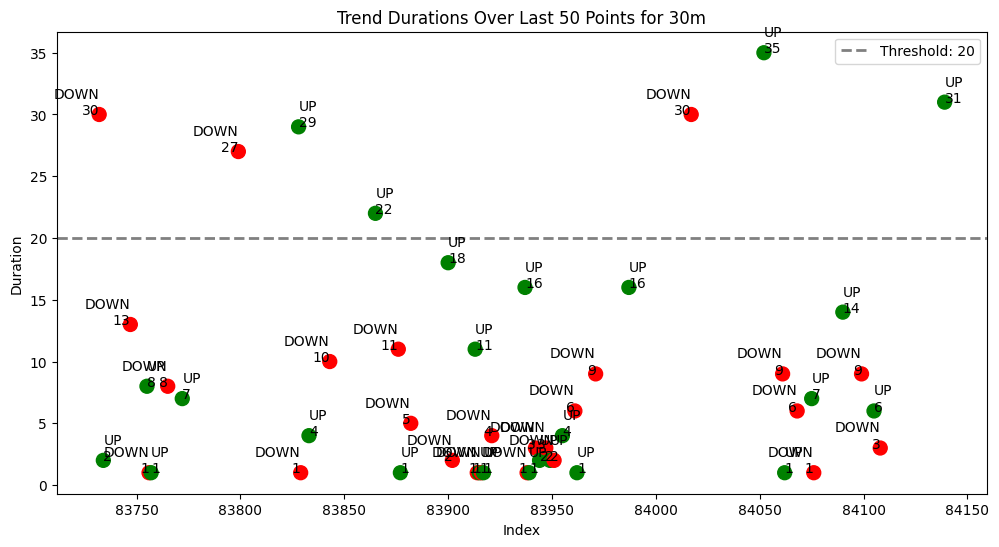

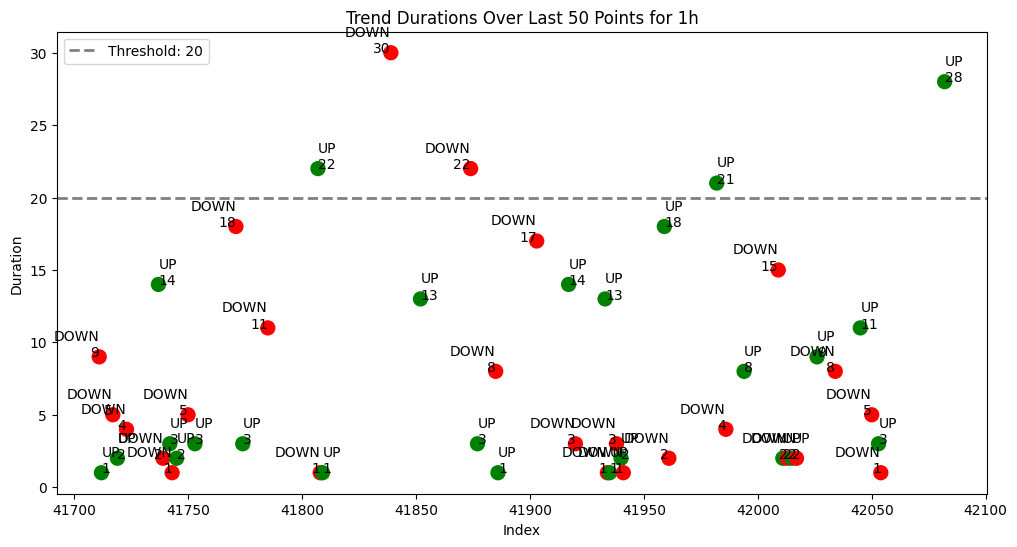

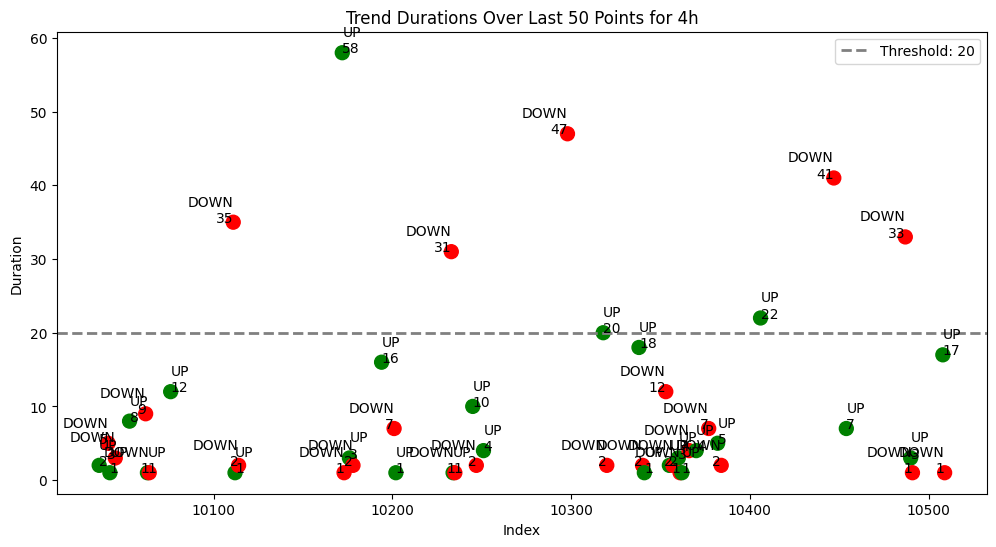

In [1]:
import feather
import pandas as pd
import talib
import numpy as np
import matplotlib.pyplot as plt

# List of timeframes to process
timeframes = ['1m', '3m', '5m', '15m', '30m', '1h', '4h']

# Base path for the dataset
base_path = '/allah/freqtrade/user_data/data/binance/futures/ETH_USDT_USDT-'

# Define trend colors once for all plots
trend_colors = {'UP': 'red', 'DOWN': 'green', 'STABLE': 'blue'}

# Loop through each timeframe and process the data
for timeframe in timeframes:
    # Construct the dataset path
    dataset_path = f'{base_path}{timeframe}-futures.feather'

    # Load the dataset
    dataframe = feather.read_dataframe(dataset_path)

    # Calculate Triple Exponential Moving Average (TEMA) on closing prices
    tema_period = 50
    dataframe['tema'] = talib.TEMA(dataframe['close'], timeperiod=tema_period)

    # Establish the trend direction
    conditions = [
        dataframe['tema'] > dataframe['tema'].shift(1),
        dataframe['tema'] < dataframe['tema'].shift(1)
    ]
    choices = ['DOWN', 'UP']
    dataframe['trend'] = np.select(conditions, choices, default='STABLE')

    # Identify trend change points
    dataframe['trend_change'] = dataframe['trend'] != dataframe['trend'].shift(1)
    dataframe['trend_change_point'] = dataframe['trend_change'] & (dataframe['trend'] != 'STABLE')

    # Create a separate DataFrame for change points to avoid SettingWithCopyWarning
    change_points = dataframe[dataframe['trend_change_point']].copy()
    change_points['duration'] = change_points.index.to_series().diff().fillna(0)

    # Format data for plotting
    change_points = change_points.round({'tema': 2, 'volume': 2})
    if 'date' in change_points.columns:
        change_points['date'] = change_points['date'].dt.strftime('%Y-%m-%d %H:%M')

    # Prepare for visualization
    plot_data = change_points.copy()
    plot_data['previous_trend'] = plot_data['trend'].shift(1)
    plot_data.dropna(subset=['duration'], inplace=True)
    plot_window = 50
    plot_data = plot_data.tail(plot_window)

    # Create the scatter plot
    plt.figure(figsize=(12, 6))
    plt.scatter(plot_data.index, plot_data['duration'],
                c=plot_data['previous_trend'].map(trend_colors),
                marker='o', s=100)

    # Additional plot formatting
    Threshold = 20
    plt.axhline(y=Threshold, color='gray', linestyle='--', linewidth=2, label=f'Threshold: {Threshold}')
    plt.xlabel('Index')
    plt.ylabel('Duration')
    plt.title(f'Trend Durations Over Last {plot_window} Points for {timeframe}')

    # Annotate points
    for idx, row in plot_data.iterrows():
        alignment = 'right' if row['trend'] == 'DOWN' else 'left'
        plt.text(idx, row['duration'], f"{row['trend']}\n{int(row['duration'])}", ha=alignment)

    plt.legend()
    plt.show()


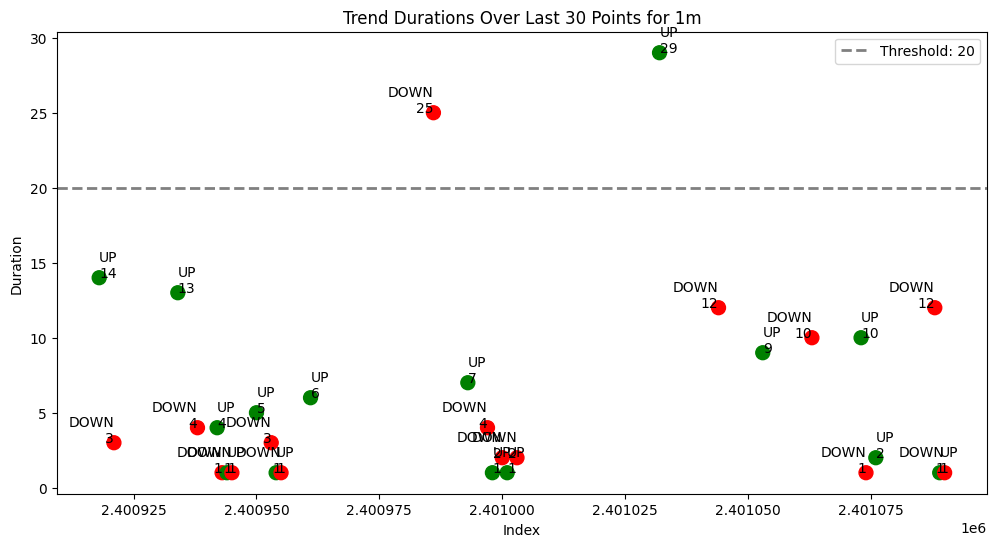

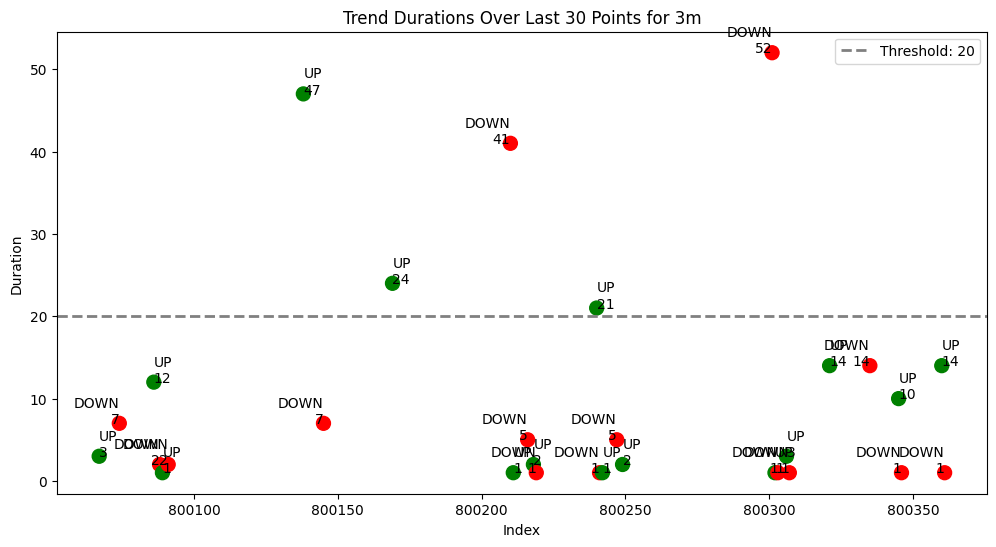

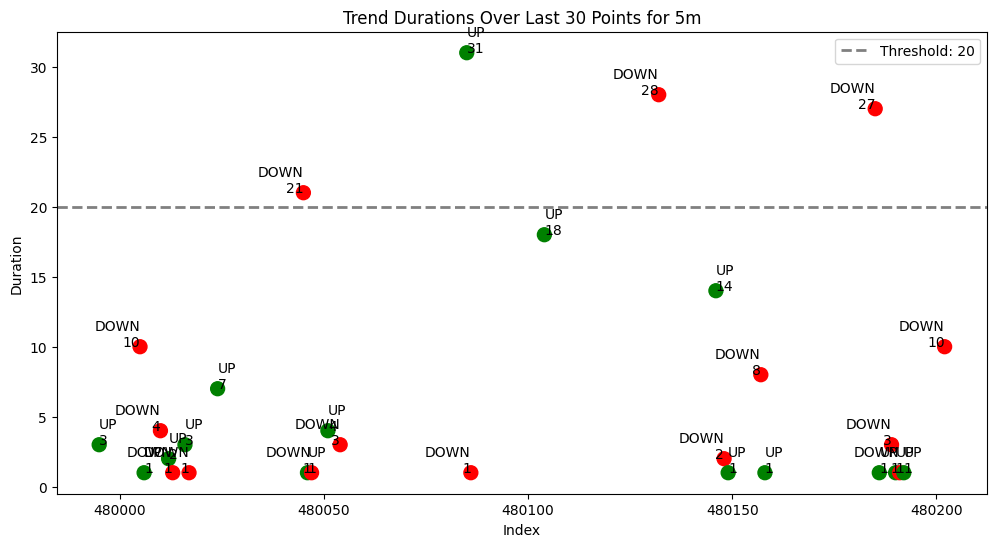

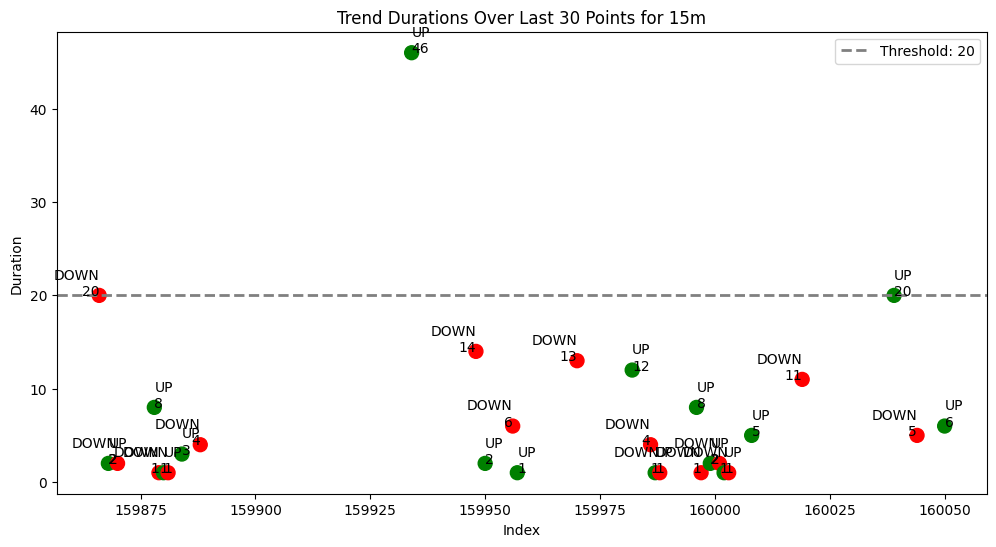

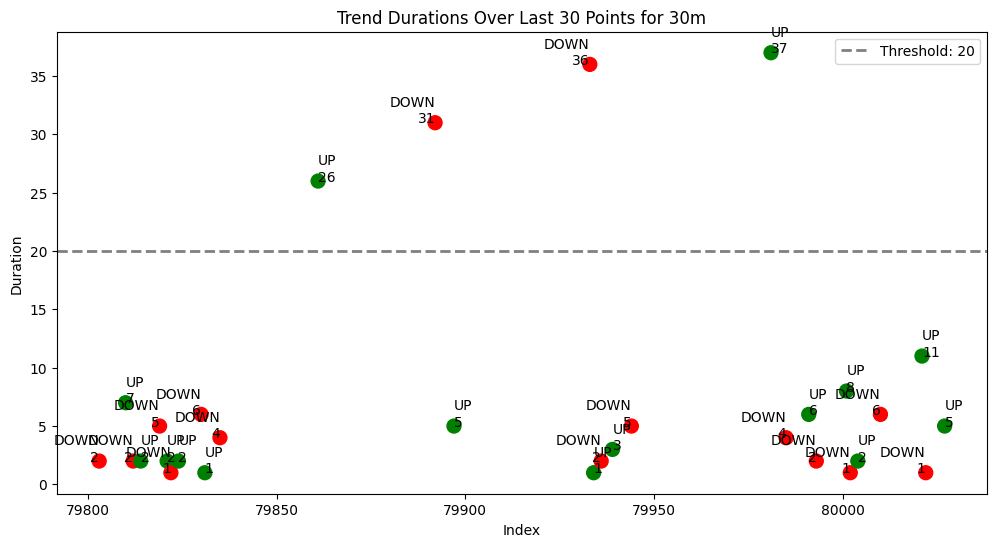

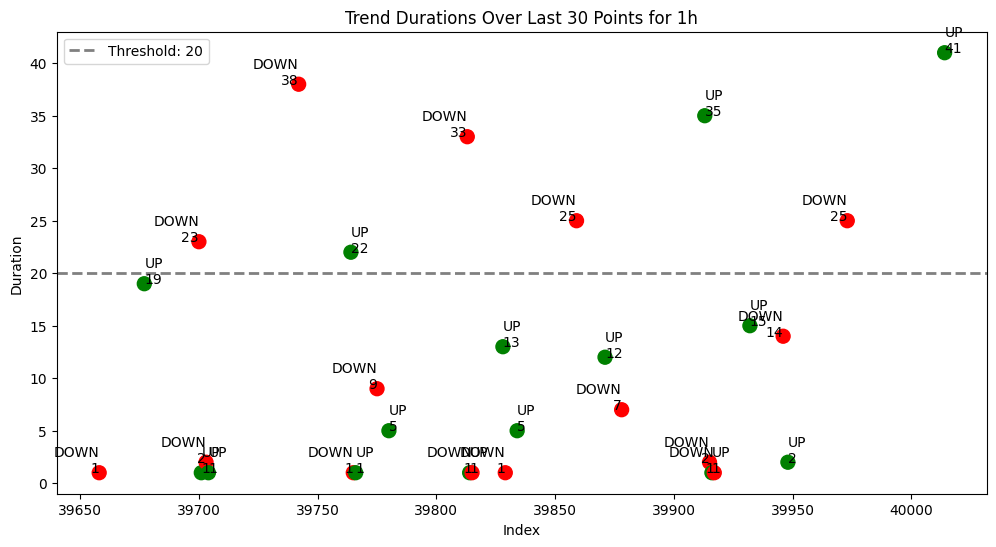

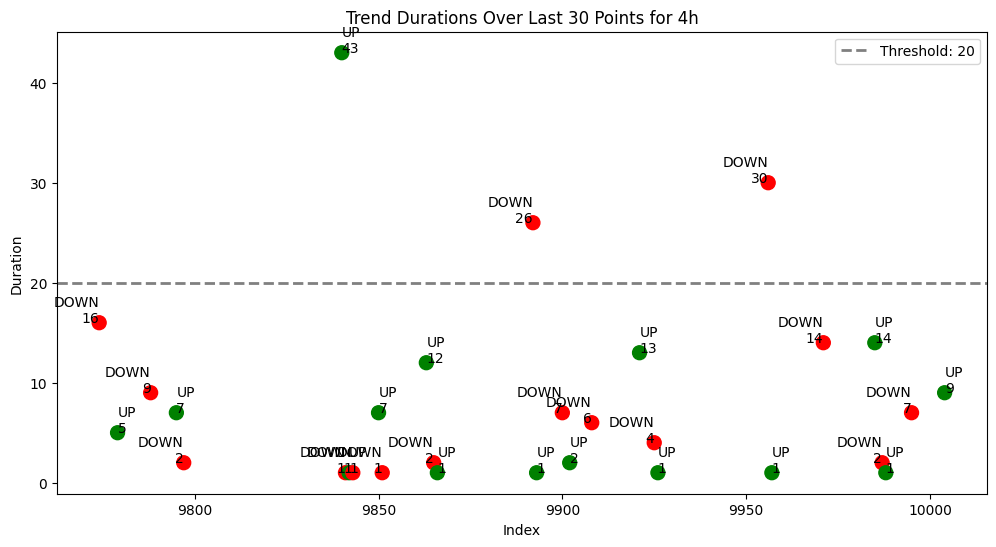

Timeframes with the most durations < 5: ['5m'] with 20 occurrences


In [12]:
import feather
import pandas as pd
import talib
import numpy as np
import matplotlib.pyplot as plt

# List of timeframes to process
timeframes = ['1m', '3m', '5m', '15m', '30m', '1h', '4h']

# Base path for the dataset
base_path = '/allah/freqtrade/user_data/data/binance/futures/ETH_USDT_USDT-'

# Define trend colors once for all plots
trend_colors = {'UP': 'red', 'DOWN': 'green', 'STABLE': 'blue'}

# Function to evaluate which timeframe has the most counts of duration < 5
def evaluate_timeframes(timeframe_counts):
    max_count = max(timeframe_counts.values())
    most_timeframes = [tf for tf, count in timeframe_counts.items() if count == max_count]
    return most_timeframes, max_count

# Initialize a dictionary to keep track of counts
duration_counts = {timeframe: 0 for timeframe in timeframes}

# Loop through each timeframe and process the data
for timeframe in timeframes:
    # Construct the dataset path
    dataset_path = f'{base_path}{timeframe}-futures.feather'

    # Load the dataset
    dataframe = feather.read_dataframe(dataset_path)

    # Calculate Triple Exponential Moving Average (TEMA) on closing prices
    tema_period = 50
    dataframe['tema'] = talib.TEMA(dataframe['close'], timeperiod=tema_period)

    # Establish the trend direction
    conditions = [
        dataframe['tema'] > dataframe['tema'].shift(1),
        dataframe['tema'] < dataframe['tema'].shift(1)
    ]
    choices = ['DOWN', 'UP']
    dataframe['trend'] = np.select(conditions, choices, default='STABLE')

    # Identify trend change points
    dataframe['trend_change'] = dataframe['trend'] != dataframe['trend'].shift(1)
    dataframe['trend_change_point'] = dataframe['trend_change'] & (dataframe['trend'] != 'STABLE')

    # Create a separate DataFrame for change points to avoid SettingWithCopyWarning
    change_points = dataframe[dataframe['trend_change_point']].copy()
    change_points['duration'] = change_points.index.to_series().diff().fillna(0)

    # Format data for plotting
    change_points = change_points.round({'tema': 2, 'volume': 2})
    if 'date' in change_points.columns:
        change_points['date'] = change_points['date'].dt.strftime('%Y-%m-%d %H:%M')

    # Prepare for visualization
    plot_data = change_points.copy()
    plot_data['previous_trend'] = plot_data['trend'].shift(1)
    plot_data.dropna(subset=['duration'], inplace=True)
    plot_window = 30
    plot_data = plot_data.tail(plot_window)

    # Update duration counts
    duration_counts[timeframe] += (plot_data['duration'] < 5).sum()

    # Create the scatter plot
    plt.figure(figsize=(12, 6))
    plt.scatter(plot_data.index, plot_data['duration'],
                c=plot_data['previous_trend'].map(trend_colors),
                marker='o', s=100)

    # Additional plot formatting
    Threshold = 20
    plt.axhline(y=Threshold, color='gray', linestyle='--', linewidth=2, label=f'Threshold: {Threshold}')
    plt.xlabel('Index')
    plt.ylabel('Duration')
    plt.title(f'Trend Durations Over Last {plot_window} Points for {timeframe}')

    # Annotate points
    for idx, row in plot_data.iterrows():
        alignment = 'right' if row['trend'] == 'DOWN' else 'left'
        plt.text(idx, row['duration'], f"{row['trend']}\n{int(row['duration'])}", ha=alignment)

    plt.legend()
    plt.show()

# Determine the timeframe with the most counts of duration < 5
most_timeframes, max_count = evaluate_timeframes(duration_counts)
print(f"Timeframes with the most durations < 5: {most_timeframes} with {max_count} occurrences")


In [11]:
def evaluate_timeframes(timeframe_counts):
    # Find the maximum count of durations under 5
    max_count = max(timeframe_counts.values())
    most_timeframes = [tf for tf, count in timeframe_counts.items() if count == max_count]
    
    # Find the minimum count of durations under 5
    min_count = min(timeframe_counts.values())
    least_timeframes = [tf for tf, count in timeframe_counts.items() if count == min_count]
    
    return most_timeframes, max_count, least_timeframes, min_count

print(evaluate_timeframes(duration_counts))

(['5m', '15m'], 31, ['4h'], 24)


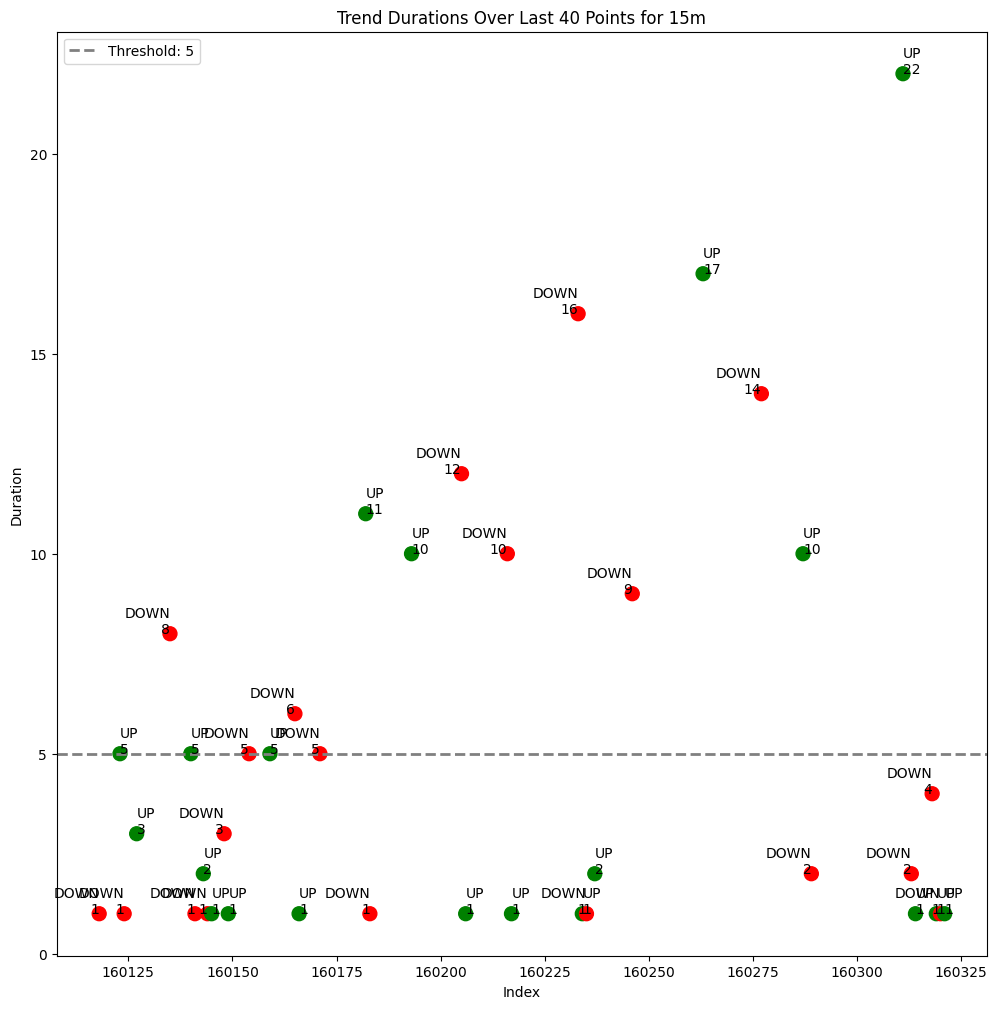

15m occurrences of duration < 5: 23
Timeframes with the most durations < 5: ['15m'] with 23 occurrences
Timeframes with the least durations < 5: ['15m'] with 23 occurrences


In [1]:
import feather
import pandas as pd
import talib
import numpy as np
import matplotlib.pyplot as plt

# List of timeframes to process
# timeframes = ['1m', '3m', '5m', '15m', '30m', '1h', '4h']
timeframes = ['15m']

# Base path for the dataset
base_path = '/allah/freqtrade/user_data/data/binance/futures/ETH_USDT_USDT-'

# Define trend colors once for all plots
trend_colors = {'UP': 'red', 'DOWN': 'green', 'STABLE': 'blue'}

# Initialize a dictionary to keep track of counts
duration_counts = {timeframe: 0 for timeframe in timeframes}

# Dictionary to store duration data for analysis
duration_data = {}

# Loop through each timeframe and process the data
for timeframe in timeframes:
    # Construct the dataset path
    dataset_path = f'{base_path}{timeframe}-futures.feather'

    # Load the dataset
    dataframe = feather.read_dataframe(dataset_path)

    # Calculate Triple Exponential Moving Average (TEMA) on closing prices
    tema_period = 50
    dataframe['tema'] = talib.TEMA(dataframe['close'], timeperiod=tema_period)

    # Establish the trend direction
    conditions = [
        dataframe['tema'] > dataframe['tema'].shift(1),
        dataframe['tema'] < dataframe['tema'].shift(1)
    ]
    choices = ['DOWN', 'UP']
    dataframe['trend'] = np.select(conditions, choices, default='STABLE')

    # Identify trend change points
    dataframe['trend_change'] = dataframe['trend'] != dataframe['trend'].shift(1)
    dataframe['trend_change_point'] = dataframe['trend_change'] & (dataframe['trend'] != 'STABLE')

    # Create a separate DataFrame for change points to avoid SettingWithCopyWarning
    change_points = dataframe[dataframe['trend_change_point']].copy()
    change_points['duration'] = change_points.index.to_series().diff().fillna(0)

    # Format data for plotting
    change_points = change_points.round({'tema': 2, 'volume': 2})
    if 'date' in change_points.columns:
        change_points['date'] = change_points['date'].dt.strftime('%Y-%m-%d %H:%M')

    # Prepare for visualization
    plot_data = change_points.copy()
    plot_data['previous_trend'] = plot_data['trend'].shift(1)
    plot_data.dropna(subset=['duration'], inplace=True)
    plot_window = 40
    plot_data = plot_data.tail(plot_window)

    # Update duration counts and store data
    count_under_five = (plot_data['duration'] < 5).sum()
    duration_counts[timeframe] += count_under_five
    duration_data[timeframe] = plot_data['duration'].values

    # Create the scatter plot
    plt.figure(figsize=(12, 12))
    plt.scatter(plot_data.index, plot_data['duration'],
                c=plot_data['previous_trend'].map(trend_colors),
                marker='o', s=100)

    # Additional plot formatting
    Threshold = 5
    plt.axhline(y=Threshold, color='gray', linestyle='--', linewidth=2, label=f'Threshold: {Threshold}')
    plt.xlabel('Index')
    plt.ylabel('Duration')
    plt.title(f'Trend Durations Over Last {plot_window} Points for {timeframe}')

    # Annotate points
    for idx, row in plot_data.iterrows():
        alignment = 'right' if row['trend'] == 'DOWN' else 'left'
        plt.text(idx, row['duration'], f"{row['trend']}\n{int(row['duration'])}", ha=alignment)

    plt.legend()
    plt.show()
    print(f"{timeframe} occurrences of duration < 5: {count_under_five}")

# Evaluate timeframes for the most and least durations < 5
def evaluate_timeframes(timeframe_counts):
    # Find the maximum count of durations under 5
    max_count = max(timeframe_counts.values())
    most_timeframes = [tf for tf, count in timeframe_counts.items() if count == max_count]
    
    # Find the minimum count of durations under 5
    min_count = min(timeframe_counts.values())
    least_timeframes = [tf for tf, count in timeframe_counts.items() if count == min_count]
    
    return most_timeframes, max_count, least_timeframes, min_count

most_timeframes, max_count, least_timeframes, min_count = evaluate_timeframes(duration_counts)
print(f"Timeframes with the most durations < 5: {most_timeframes} with {max_count} occurrences")
print(f"Timeframes with the least durations < 5: {least_timeframes} with {min_count} occurrences")
